In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from glob import glob
import numpy as np
import matplotlib.patches as mpatches


In [9]:
# Util Functions

# Get positive pairs
def get_positive_pairs(x, y):

    """Create positive pairs from same-class samples"""
    pairs = []
    labels = []
    for label in torch.unique(y):
        mask = y == label
        indices = torch.where(mask)[0]
        if len(indices) < 2:
            continue
        # Randomly select pairs of samples from same class
        idx1 = indices[torch.randperm(len(indices))[:len(indices)//2]]
        idx2 = indices[torch.randperm(len(indices))[:len(indices)//2]]
        pairs.extend(list(zip(idx1.tolist(), idx2.tolist())))
        labels.extend([1] * (len(indices)//2))  # 1 indicates positive pair
    return torch.tensor(pairs), torch.tensor(labels)

# Contrastive model
class ContrastiveModel(nn.Module):
    def __init__(self, input_dim, embedding_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, embedding_dim)
        )
        
    def forward(self, x):
        return F.normalize(self.encoder(x), dim=1)


# Train contrastive model
def train_contrastive(model, dataloader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CosineEmbeddingLoss()

    history = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x1, x2, y in dataloader:
            optimizer.zero_grad()
            
            # Get embeddings
            z1 = model(x1)
            z2 = model(x2)
            
            # Compute loss
            loss = criterion(z1, z2, y)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss/len(dataloader)
        history.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return history


def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history)
    plt.title('Contrastive Learning Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()


def visualize_embeddings(embeddings, y): 

    # Ensure both are numpy arrays
    emb = np.asarray(embeddings)
    y = np.asarray(y)

    # Align sizes (take min length)
    n = min(emb.shape[0], y.shape[0])
    emb = emb[:n]
    y = y[:n]

    # Plot the embeddings 
    plt.figure(figsize=(12, 8)) 
    scatter = plt.scatter(emb[:, 0], emb[:, 1], c=y, cmap='viridis', alpha=0.6)

    legend_elements = [
        mpatches.Patch(color=plt.cm.viridis(0.0), label='Class 0'),
        mpatches.Patch(color=plt.cm.viridis(1.0), label='Class 1')
    ]
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization of Learned Embeddings') 
    plt.xlabel('t-SNE 1') 
    plt.ylabel('t-SNE 2') 
    plt.legend(title="Class", loc='upper right', handles=legend_elements)
    plt.show()



In [3]:
datasets =  glob("./processed_datasets/*.csv")
for dataset in datasets:
    print(dataset)

./processed_datasets/dataset_preprocessed_smote.csv
./processed_datasets/dataset_preprocessed_adasyn.csv


=== dataset_preprocessed_smote ===
Epoch 1, Loss: 0.6978
Epoch 2, Loss: 0.0796
Epoch 3, Loss: 0.0120
Epoch 4, Loss: 0.0049
Epoch 5, Loss: 0.0021
Epoch 6, Loss: 0.0014
Epoch 7, Loss: 0.0008
Epoch 8, Loss: 0.0006
Epoch 9, Loss: 0.0004
Epoch 10, Loss: 0.0003
Epoch 11, Loss: 0.0002
Epoch 12, Loss: 0.0002
Epoch 13, Loss: 0.0002
Epoch 14, Loss: 0.0001
Epoch 15, Loss: 0.0001


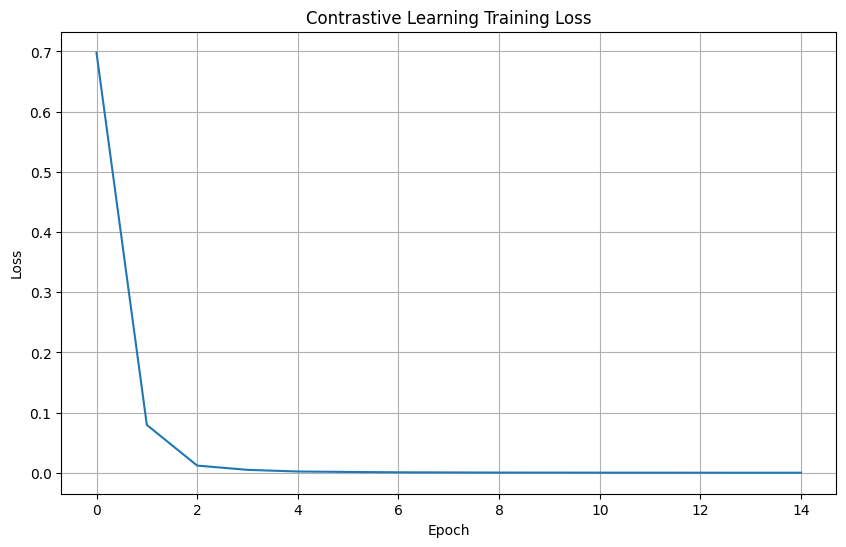

Embeddings saved successfully!

--------------------------------

=== dataset_preprocessed_adasyn ===
Epoch 1, Loss: 0.6772
Epoch 2, Loss: 0.0805
Epoch 3, Loss: 0.0146
Epoch 4, Loss: 0.0056
Epoch 5, Loss: 0.0031
Epoch 6, Loss: 0.0017
Epoch 7, Loss: 0.0013
Epoch 8, Loss: 0.0010
Epoch 9, Loss: 0.0008
Epoch 10, Loss: 0.0005
Epoch 11, Loss: 0.0004
Epoch 12, Loss: 0.0003
Epoch 13, Loss: 0.0003
Epoch 14, Loss: 0.0003
Epoch 15, Loss: 0.0003


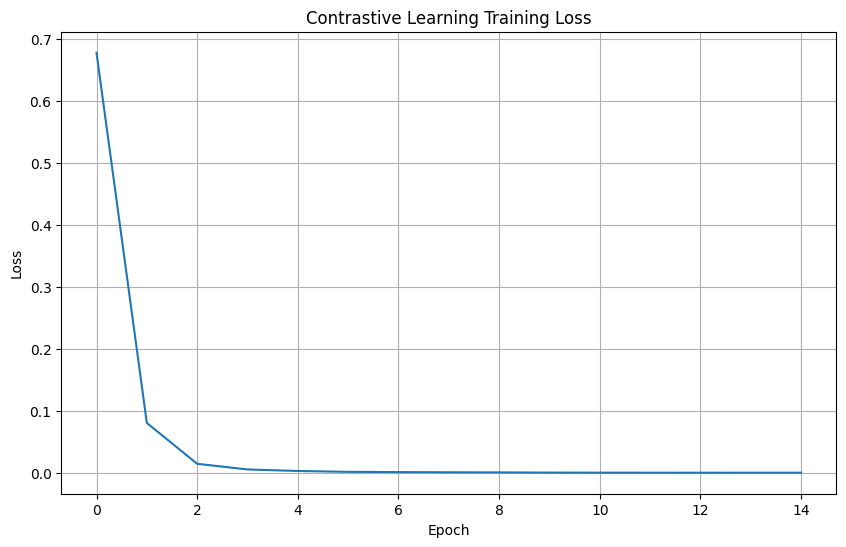

Embeddings saved successfully!

--------------------------------



In [5]:
embeddings_dict = {}
target = "Gestational Diabetes" 
for dataset in datasets:
    print(f"=== {dataset.split("/")[-1].strip(".csv")} ===")
    # Read dataset
    df = pd.read_csv(dataset)
    # Split dataset 
    X = df.drop(target, axis=1)
    y = df[target]

    # Convert to tensors
    X_tensor = torch.FloatTensor(X.values)
    y_tensor = torch.LongTensor(y.values)

    # Create positive pairs
    pairs, labels = get_positive_pairs(X_tensor, y_tensor)

    # Create DataLoader
    df = TensorDataset(X_tensor[pairs[:, 0]], X_tensor[pairs[:, 1]], labels)
    dataloader = DataLoader(df, batch_size=256, shuffle=True)

    # Initialize model
    input_dim = X_tensor.shape[1]
    model = ContrastiveModel(input_dim)

    # Train model
    history = train_contrastive(model, dataloader, epochs=15)

    # Plot loss
    plot_loss(history)

    # Get embeddings
    model.eval()
    with torch.no_grad():
        embeddings = model(X_tensor)

    embeddings_dict[dataset.split("/")[-1].strip(".csv")] = embeddings
    # Save embeddings
    embeddings_df = pd.DataFrame(embeddings.numpy())
    embeddings_df[target] = y
    embeddings_df.to_csv(f"./processed_datasets/CL/dataset_{dataset.split("/")[-1].strip(".csv")}_CL.csv", index=False)

    print("Embeddings saved successfully!")
    print("\n--------------------------------\n")

In [6]:
# Visualize the embeddings of the hybrid approach
tsne = TSNE(n_components=3, random_state=42) 
embeddings_2d = tsne.fit_transform(embeddings_dict["dataset_preprocessed_smote"].numpy()) 

/Users/sindabesrour/Projects/gestationalDiabetesPrediction/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sindabesrour/Projects/gestationalDiabetesPrediction/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sindabesrour/Projects/gestationalDiabetesPrediction/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sindabesrour/Projects/gestationalDiabetesPrediction/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/sindabesrour/Projects/gestationalDiabetesPrediction/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)

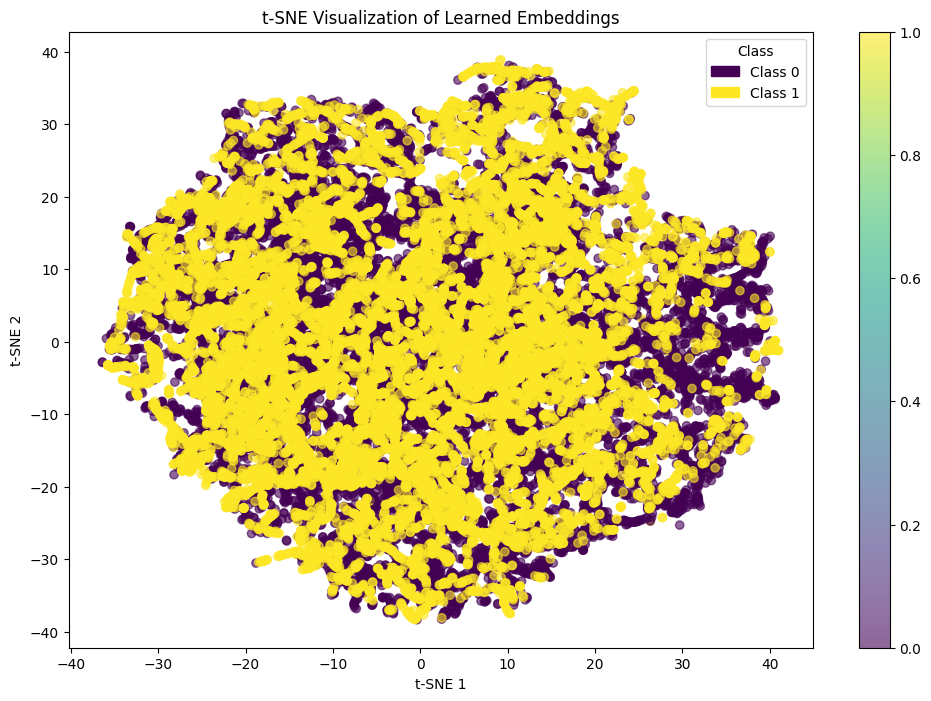

In [10]:
visualize_embeddings(embeddings_2d, y)